# Conformal Prediction with Cluster & k-NN Smoothing
### Group 51 – Technical Notebook

This notebook contains the full code corresponding to our 4-page report, including:
- baseline split conformal prediction
- feature extraction
- cluster smoothing
- k-NN smoothing
- hyperparameter sweeps and plotting scripts
- evaluation & comparison among different methods

## Setup
We import all necessary libraries for model training, evaluation, and plotting.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

#from conformal.data import IndexedDataset
#from conformal.train import train_model, evaluate_and_save
from functools import partial
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

## 1. Data preprocessing & Baseline classifier training 
We use CIFAR-10 with standard resizing and normalization. 
We follow the same splits as the project template:
- 60% train
- 20% validation
- 20% holdout calibration set for conformal prediction.

We use a pretrained ResNet-18 and fine-tune the final linear layer to output 10 classes.
Training code is the same as in the course template.

In [ ]:
# DO NOT RUN THIS CELL ON YOUR LOCAL COMPUTER. ONLY RUN THIS ON HPC.

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    folder = "scratch/rhti/conformal"
    num_workers = 6
    val_frac = 0.2
    holdout_frac = 0.2
    epochs = 10
    lr = 1e-3

    # Data transforms
    transform_train = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )
    transform_test = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ]
    )

    # Datasets and loaders
    full_trainset = IndexedDataset(
        datasets.CIFAR10(
            root=folder + "/data", train=True, download=True, transform=transform_train
        )
    )
    val_size = int(val_frac * len(full_trainset))
    holdout_size = int(holdout_frac * len(full_trainset))
    train_size = len(full_trainset) - val_size - holdout_size
    trainset, valset, holdoutset = torch.utils.data.random_split(
        full_trainset, [train_size, val_size, holdout_size]
    )
    testset = IndexedDataset(
        datasets.CIFAR10(
            root=folder + "/data", train=False, download=True, transform=transform_test
        )
    )

    dataloader_settings = partial(
        torch.utils.data.DataLoader,
        batch_size=64,
        num_workers=num_workers,
        pin_memory=True if device.type == "cuda" else False,
        persistent_workers=True,
    )

    trainloader = dataloader_settings(trainset, shuffle=True, drop_last=True)
    valloader = dataloader_settings(valset, shuffle=False)
    testloader = dataloader_settings(testset, shuffle=False)
    holdoutloader = dataloader_settings(holdoutset, shuffle=False)

    # Model setup
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)

    # Train the model
    model = train_model(model, trainloader, valloader, device, epochs=epochs, lr=lr)

    # Evaluation on validation set
    evaluate_and_save(model, valloader, device, folder, "val_predictions.pth")

    # Evaluation on test set
    evaluate_and_save(model, testloader, device, folder, "test_predictions.pth")

    # Save the model and predictions on the holdout set
    torch.save(model.state_dict(), folder + "/cifar10_resnet18.pth")
    evaluate_and_save(model, holdoutloader, device, folder, "holdout_predictions.pth")


if __name__ == "__main__":
    main()


Training was executed on DTU HPC for power efficiency (see examples/scratch folder).

## 2. Baseline split conformal prediction
We follow the standard conformal prediction procedures:
1. Train on train set
2. Compute conformity scores on holdout set
3. Apply threshold on validation/test predictions

We evaluate:
- Coverage (should be ≥ 1 − α)
- Efficiency = mean |prediction set|
- Singleton coverage (% of predictions where the set contains exactly one class)

In [3]:
# Load stored predictions
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    folder = "examples/scratch/rhti/conformal"

    holdout_results = torch.load(folder + "/holdout_predictions.pth")
    val_results = torch.load(folder + "/val_predictions.pth")

    cal_labels = holdout_results["labels"]
    cal_outputs = holdout_results["outputs"]
    val_outputs = val_results["outputs"]
    val_labels = val_results["labels"]
    alpha = 0.1  # 90% prediction intervals

    # Do conformal calibration
    n = len(cal_labels)
    cal_scores = 1 - cal_outputs[np.arange(n), cal_labels]
    q_level = np.ceil((n + 1) * (1 - alpha)) / n        # nonconformity score s_i
    qhat = np.quantile(cal_scores, q_level, interpolation="higher") # quantile calculation
    prediction_sets = val_outputs >= (1 - qhat)  # form prediction sets

    empirical_coverage = prediction_sets[
        np.arange(prediction_sets.shape[0]), val_labels
    ].mean()

    print(f"Empirical coverage on validation set: {empirical_coverage * 100:.2f}%")

    empirical_efficiency = prediction_sets.sum(-1).mean()

    print(f"Empirical efficiency on validation set: {empirical_efficiency:.2f}")

    singletons_idx = prediction_sets.sum(-1) == 1
    empirical_singleton = prediction_sets[
        np.arange(prediction_sets.shape[0]), val_labels
    ][singletons_idx].mean()
    print(
        f"Empirical singleton coverage on validation set: {empirical_singleton * 100:.2f}%"
    )


if __name__ == "__main__":
    main()


Empirical coverage on validation set: 90.16%
Empirical efficiency on validation set: 1.14
Empirical singleton coverage on validation set: 94.97%


C:\Users\My Lan\AppData\Local\Temp\ipykernel_4824\3393329188.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  holdout_results = torch.load(folder + "/holdout_predictions

## 3. Feature extraction
We extract the representation from the last hidden layer of ResNet-18 
(before the final linear classifier). 
These 512-dim embeddings are used for local smoothing (cluster / k-NN).


In [4]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    folder = "examples/scratch/rhti/conformal"

    transform_train = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010),
            ),
        ]
    )

    # Load CIFAR10 train
    base_trainset = datasets.CIFAR10(
        root=folder + "/data",
        train=True,
        download=False,
        transform=transform_train,
    )

    # Load holdout + val prediction files
    holdout_results = torch.load(folder + "/holdout_predictions.pth", weights_only=False)
    val_results = torch.load(folder + "/val_predictions.pth", weights_only=False)

    holdout_idx = holdout_results["indexes"]
    val_idx = val_results["indexes"]

    all_idx = np.concatenate([holdout_idx, val_idx], axis=0)

    subset = Subset(base_trainset, all_idx)

    loader = DataLoader(
        subset,
        batch_size=128,
        shuffle=False,
        num_workers=4,
    )

    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.load_state_dict(torch.load(folder + "/cifar10_resnet18.pth", map_location=device))
    model = model.to(device)
    model.eval()

    # Create feature extractor (remove final layer)
    feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
    feature_extractor.eval()

    all_features = []

    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)       # [B, 512, 1, 1]
            feats = feats.view(feats.size(0), -1) # [B, 512]
            all_features.append(feats.cpu())

    all_features = torch.cat(all_features, dim=0).numpy()  # [N_total, 512]

    # Split back into holdout and val features
    n_holdout = len(holdout_idx)
    holdout_features = all_features[:n_holdout]
    val_features = all_features[n_holdout:]

    np.savez(
        folder + "/holdout_features.npz",
        indexes=holdout_idx,
        features=holdout_features,
    )

    np.savez(
        folder + "/val_features.npz",
        indexes=val_idx,
        features=val_features,
    )

    print("Saved holdout_features.npz and val_features.npz")


if __name__ == "__main__":
    main()


C:\Users\My Lan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\My Lan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\My Lan\AppData\Local\Temp\ipykernel_4824\288285375.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futur

Saved holdout_features.npz and val_features.npz


## 4. Cluster smoothing
We group the calibration features using K-Means.
Each cluster gets its own local conformal threshold, blended with the global
threshold using smoothing strength λ.

In [6]:
def evaluate_cp(cal_scores_use, val_outputs_use, val_labels_use, alpha=0.1, desc=""):
    """
    Helper: given calibration scores (1D), and validation outputs/labels,
    compute qhat, coverage, efficiency, singleton coverage.
    """
    n = len(cal_scores_use)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    qhat = np.quantile(cal_scores_use, q_level, interpolation="higher")

    pred_sets = val_outputs_use >= (1.0 - qhat)

    coverage = pred_sets[np.arange(len(val_labels_use)), val_labels_use].mean()
    eff = pred_sets.sum(axis=-1).mean()
    singleton_idx = pred_sets.sum(axis=-1) == 1
    if singleton_idx.any():
        singleton_cov = pred_sets[
            np.arange(len(val_labels_use)), val_labels_use
        ][singleton_idx].mean()
    else:
        singleton_cov = float("nan")

    print(
        f"{desc}Coverage: {coverage*100:.2f}%, "
        f"efficiency: {eff:.2f}, "
        f"singleton cov: {singleton_cov*100:.2f}%"
    )
    return qhat, coverage, eff, singleton_cov


def main():
    folder = "examples/scratch/rhti/conformal"
    alpha = 0.1  

    holdout_results = torch.load(
        folder + "/holdout_predictions.pth", weights_only=False
    )
    val_results = torch.load(folder + "/val_predictions.pth", weights_only=False)

    cal_labels = holdout_results["labels"]          # shape [n_cal]
    cal_outputs = holdout_results["outputs"]        # shape [n_cal, 10]
    val_labels = val_results["labels"]              # shape [n_val]
    val_outputs = val_results["outputs"]            # shape [n_val, 10]

    n_cal = len(cal_labels)
    n_val = len(val_labels)

    cal_scores = 1.0 - cal_outputs[np.arange(n_cal), cal_labels]
    val_scores = 1.0 - val_outputs[np.arange(n_val), val_labels]

    print("=== Baseline CP (no clustering) ===")
    evaluate_cp(cal_scores, val_outputs, val_labels, alpha=alpha, desc="Baseline: ")

    holdout_feat = np.load(folder + "/holdout_features.npz")
    val_feat = np.load(folder + "/val_features.npz")

    cal_features = holdout_feat["features"]   # shape [n_cal, 512]
    val_features = val_feat["features"]       # shape [n_val, 512]

    num_clusters = 50
    print(f"\nFitting KMeans with {num_clusters} clusters on calibration features...")
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cal_clusters = kmeans.fit_predict(cal_features)   
    val_clusters = kmeans.predict(val_features)      

    cluster_means = np.zeros(num_clusters, dtype=np.float64)
    global_mean = cal_scores.mean()
    for c in range(num_clusters):
        idx = (cal_clusters == c)
        if idx.any():
            cluster_means[c] = cal_scores[idx].mean()
        else:
            cluster_means[c] = global_mean

    for lam in [0.1, 0.2, 0.3]:
        # s_tilde(i) = (1 - lam) * s(i) + lam * mean_score_of_cluster(i)
        cal_scores_smooth = (1.0 - lam) * cal_scores + lam * cluster_means[cal_clusters]

        print(f"\n=== Cluster-smoothed CP with lambda = {lam} ===")
        evaluate_cp(
            cal_scores_smooth,
            val_outputs,
            val_labels,
            alpha=alpha,
            desc=f"lambda={lam}: ",
        )


if __name__ == "__main__":
    main()


=== Baseline CP (no clustering) ===
Baseline: Coverage: 90.16%, efficiency: 1.14, singleton cov: 94.97%

Fitting KMeans with 50 clusters on calibration features...


C:\Users\My Lan\AppData\Local\Temp\ipykernel_4824\1151427969.py:60: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  evaluate_cp(cal_scores, val_outputs, val_labels, alpha=alpha, desc="Baseline: ")



=== Cluster-smoothed CP with lambda = 0.1 ===
lambda=0.1: Coverage: 89.47%, efficiency: 1.11, singleton cov: 95.11%

=== Cluster-smoothed CP with lambda = 0.2 ===
lambda=0.2: Coverage: 88.63%, efficiency: 1.09, singleton cov: 95.22%

=== Cluster-smoothed CP with lambda = 0.3 ===
lambda=0.3: Coverage: 88.01%, efficiency: 1.07, singleton cov: 95.42%


C:\Users\My Lan\AppData\Local\Temp\ipykernel_4824\1151427969.py:94: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  evaluate_cp(


Effect of parameters:
- K controls how fine-grained local smoothing becomes.
- λ controls strength of local vs global calibration.

## 5. k-NN smoothing
Instead of using hard clusters, each validation/test point is smoothed using its
k nearest calibration features in latent space.


In [8]:
def evaluate_cp(cal_scores_use, val_outputs_use, val_labels_use, alpha=0.1, desc=""):
    """
    Given calibration scores (1D), and validation outputs/labels,
    compute qhat, coverage, efficiency, singleton coverage.
    """
    n = len(cal_scores_use)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    qhat = np.quantile(cal_scores_use, q_level, method="higher")

    pred_sets = val_outputs_use >= (1.0 - qhat)

    coverage = pred_sets[np.arange(len(val_labels_use)), val_labels_use].mean()
    eff = pred_sets.sum(axis=-1).mean()
    singleton_idx = pred_sets.sum(axis=-1) == 1
    if singleton_idx.any():
        singleton_cov = pred_sets[
            np.arange(len(val_labels_use)), val_labels_use
        ][singleton_idx].mean()
    else:
        singleton_cov = float("nan")

    print(
        f"{desc}Coverage: {coverage*100:.2f}%, "
        f"efficiency: {eff:.2f}, "
        f"singleton cov: {singleton_cov*100:.2f}%"
    )
    return qhat, coverage, eff, singleton_cov


def main():
    folder = "examples/scratch/rhti/conformal"
    alpha = 0.1  

    holdout_results = torch.load(
        folder + "/holdout_predictions.pth", weights_only=False
    )
    val_results = torch.load(folder + "/val_predictions.pth", weights_only=False)

    cal_labels = holdout_results["labels"]          # [n_cal]
    cal_outputs = holdout_results["outputs"]        # [n_cal, 10]
    val_labels = val_results["labels"]              # [n_val]
    val_outputs = val_results["outputs"]            # [n_val, 10]
    n_cal = len(cal_labels)
    n_val = len(val_labels)
    cal_scores = 1.0 - cal_outputs[np.arange(n_cal), cal_labels]
    val_scores = 1.0 - val_outputs[np.arange(n_val), val_labels]

    print("=== Baseline CP (no k-NN smoothing) ===")
    evaluate_cp(cal_scores, val_outputs, val_labels, alpha=alpha, desc="Baseline: ")

    holdout_feat = np.load(folder + "/holdout_features.npz")
    val_feat = np.load(folder + "/val_features.npz")

    cal_features = holdout_feat["features"]   # [n_cal, 512]
    val_features = val_feat["features"]       # [n_val, 512] 

    k = 10
    print(f"\nFitting k-NN (k={k}) on calibration features...")
    nbrs = NearestNeighbors(
        n_neighbors=k,
        algorithm="auto",
        metric="euclidean",
        n_jobs=-1,
    )
    nbrs.fit(cal_features)
    distances, indices = nbrs.kneighbors(cal_features)
    neighbor_means = cal_scores[indices].mean(axis=1)  # [n_cal]

    for lam in [0.1, 0.25, 0.5]:
        # s_tilde(i) = (1 - lam) * s(i) + lam * mean_score_of_neighbors(i)
        cal_scores_smooth = (1.0 - lam) * cal_scores + lam * neighbor_means

        print(f"\n=== k-NN-smoothed CP with lambda = {lam} ===")
        evaluate_cp(
            cal_scores_smooth,
            val_outputs,
            val_labels,
            alpha=alpha,
            desc=f"kNN lambda={lam}: ",
        )


if __name__ == "__main__":
    main()


=== Baseline CP (no k-NN smoothing) ===
Baseline: Coverage: 90.16%, efficiency: 1.14, singleton cov: 94.97%

Fitting k-NN (k=10) on calibration features...

=== k-NN-smoothed CP with lambda = 0.1 ===
kNN lambda=0.1: Coverage: 89.76%, efficiency: 1.12, singleton cov: 95.04%

=== k-NN-smoothed CP with lambda = 0.25 ===
kNN lambda=0.25: Coverage: 89.31%, efficiency: 1.11, singleton cov: 95.20%

=== k-NN-smoothed CP with lambda = 0.5 ===
kNN lambda=0.5: Coverage: 88.07%, efficiency: 1.07, singleton cov: 95.39%


## 6. Hyperparameter sweeps

We sweep the parameters:
- Cluster smoothing: K ∈ {50, 110, 170} and λ ∈ {0.01, 0.02, 0.05, 0.1}
- k-NN smoothing: k ∈ {2, 8, 14} and λ ∈ {0.01, 0.025, 0.05, 0.1}

Plots below show the impact on coverage and efficiency.


### 6.1 Clustering

In [94]:
folder = "code/examples/scratch/rhti/conformal"
alpha = 0.1
target_cov = 1.0 - alpha

holdout = torch.load(folder + "/holdout_predictions.pth", weights_only=False)
val = torch.load(folder + "/val_predictions.pth", weights_only=False)
test = torch.load(folder + "/test_predictions.pth", weights_only=False)
feats = np.load(folder + "/holdout_features.npz")["features"]

cal_labels = holdout["labels"]
cal_outputs = holdout["outputs"]
n_cal = len(cal_labels)
cal_scores = 1.0 - cal_outputs[np.arange(n_cal), cal_labels]

data = {
    "cal_scores": cal_scores,
    "cal_feats": feats,
    "val_labels": val["labels"],
    "val_outputs": val["outputs"],
    "test_labels": test["labels"],
    "test_outputs": test["outputs"],
}

clustering_results_global = []

def compute_qhat(cal_scores, alpha=0.1):
    n = len(cal_scores)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    return np.quantile(cal_scores, q_level, method="higher")

def evaluate_and_return_metrics(qhat, outputs, labels, desc=""):
    pred_sets = outputs >= (1.0 - qhat)
    coverage = pred_sets[np.arange(len(labels)), labels].mean()
    eff = pred_sets.sum(axis=-1).mean()
    singleton_idx = pred_sets.sum(axis=-1) == 1
    if singleton_idx.any():
        singleton_cov = pred_sets[np.arange(len(labels)), labels][singleton_idx].mean()
    else:
        singleton_cov = np.nan
        
    result_str = f"{desc}Coverage: {coverage*100:.2f}%, Eff: {eff:.2f}, Single: {singleton_cov*100:.5f}%"
    
    return {
        "qhat": qhat,
        "coverage": coverage,
        "efficiency": eff,
        "singleton_cov": singleton_cov,
        "result_str": result_str
    }

print("Calibration Results (Baseline)")
qhat_base = compute_qhat(cal_scores, alpha)
baseline_metrics = evaluate_and_return_metrics(qhat_base, data["val_outputs"], data["val_labels"], "Baseline CAL: ")
clustering_results_global.append(("BASELINE", baseline_metrics))
print(baseline_metrics["result_str"])

Ks = list(range(20, 201, 20)) #[50, 110, 170]
lambdas = [round(0.01 + i * 0.05, 2) for i in range(20)]
 # [0.01, 0.02, 0.05, 0.1]

for K in Ks:
    print(f"CLUSTERING K={K}")
    kmeans = KMeans(n_clusters=K, random_state=0, n_init='auto')
    clusters = kmeans.fit_predict(data["cal_feats"])

    cluster_means = np.zeros(K)
    global_mean = data["cal_scores"].mean()
    for c in range(K):
        idx = clusters == c
        if idx.any():
            cluster_means[c] = data["cal_scores"][idx].mean()
        else:
            cluster_means[c] = global_mean

    for lam in lambdas:
        smooth_scores = (1.0 - lam) * data["cal_scores"] + lam * cluster_means[clusters]
        qhat = compute_qhat(smooth_scores, alpha)
        
        metrics = evaluate_and_return_metrics(qhat, data["val_outputs"], data["val_labels"], "CAL: ")
        
        config_name = f"K={K}, lambda={lam}"
        clustering_results_global.append((config_name, metrics))
        
        print(f"    lambda={lam:}: {metrics['result_str']}")

Calibration Results (Baseline)
Baseline CAL: Coverage: 90.16%, Eff: 1.14, Single: 94.96955%
CLUSTERING K=20
    lambda=0.01: CAL: Coverage: 90.04%, Eff: 1.13, Single: 94.98876%
    lambda=0.06: CAL: Coverage: 89.44%, Eff: 1.11, Single: 95.16256%
    lambda=0.11: CAL: Coverage: 88.86%, Eff: 1.09, Single: 95.12894%
    lambda=0.16: CAL: Coverage: 88.20%, Eff: 1.08, Single: 95.32552%
    lambda=0.21: CAL: Coverage: 87.60%, Eff: 1.06, Single: 95.47043%
    lambda=0.26: CAL: Coverage: 86.88%, Eff: 1.04, Single: 95.62912%
    lambda=0.31: CAL: Coverage: 86.05%, Eff: 1.02, Single: 95.65217%
    lambda=0.36: CAL: Coverage: 85.46%, Eff: 1.00, Single: 95.67283%
    lambda=0.41: CAL: Coverage: 84.90%, Eff: 0.99, Single: 95.82051%
    lambda=0.46: CAL: Coverage: 84.25%, Eff: 0.97, Single: 95.91915%
    lambda=0.51: CAL: Coverage: 83.68%, Eff: 0.96, Single: 96.05263%
    lambda=0.56: CAL: Coverage: 83.14%, Eff: 0.95, Single: 96.04859%
    lambda=0.61: CAL: Coverage: 82.63%, Eff: 0.94, Single: 96.06

In [11]:
clustering_results_global

[('BASELINE',
  {'qhat': np.float32(-1.8755414),
   'coverage': np.float64(0.9016),
   'efficiency': np.float64(1.1376),
   'singleton_cov': np.float64(0.9496955255493779),
   'result_str': 'Baseline CAL: Coverage: 90.16%, Eff: 1.14, Single: 94.96955%'}),
 ('K=20, lambda=0.01',
  {'qhat': np.float64(-1.9079369115829468),
   'coverage': np.float64(0.9004),
   'efficiency': np.float64(1.1332),
   'singleton_cov': np.float64(0.9498876107364802),
   'result_str': 'CAL: Coverage: 90.04%, Eff: 1.13, Single: 94.98876%'}),
 ('K=20, lambda=0.06',
  {'qhat': np.float64(-2.068760538101196),
   'coverage': np.float64(0.8944),
   'efficiency': np.float64(1.1115),
   'singleton_cov': np.float64(0.9516255899318301),
   'result_str': 'CAL: Coverage: 89.44%, Eff: 1.11, Single: 95.16256%'}),
 ('K=20, lambda=0.11',
  {'qhat': np.float64(-2.2221137428283693),
   'coverage': np.float64(0.8886),
   'efficiency': np.float64(1.0936),
   'singleton_cov': np.float64(0.9512893982808023),
   'result_str': 'CAL: C

In [ ]:
import re

plot_data_clustering = {}   

for label, metrics in clustering_results_global:
    if label == "BASELINE":
        K = "BASELINE"
        lam = None
    else:
        match = re.match(r"K=(\d+), lambda=([0-9.]+)", label)
        if match:
            K = int(match.group(1))
            lam = float(match.group(2))
        else:
            continue

    if K not in plot_data_clustering:
        plot_data_clustering[K] = {"lambda": [], "coverage": [], "efficiency": [],
                        "singleton_cov": [], "qhat": []}

    # Append values
    plot_data_clustering[K]["lambda"].append(lam)
    plot_data_clustering[K]["coverage"].append(float(metrics["coverage"]))
    plot_data_clustering[K]["efficiency"].append(float(metrics["efficiency"]))
    plot_data_clustering[K]["singleton_cov"].append(float(metrics["singleton_cov"]))
    plot_data_clustering[K]["qhat"].append(float(metrics["qhat"]))

In [13]:
plot_data_clustering

{'BASELINE': {'lambda': [None],
  'coverage': [0.9016],
  'efficiency': [1.1376],
  'singleton_cov': [0.9496955255493779],
  'qhat': [-1.8755414485931396]},
 20: {'lambda': [0.01,
   0.06,
   0.11,
   0.16,
   0.21,
   0.26,
   0.31,
   0.36,
   0.41,
   0.46,
   0.51,
   0.56,
   0.61,
   0.66,
   0.71,
   0.76,
   0.81,
   0.86,
   0.91,
   0.96],
  'coverage': [0.9004,
   0.8944,
   0.8886,
   0.882,
   0.876,
   0.8688,
   0.8605,
   0.8546,
   0.849,
   0.8425,
   0.8368,
   0.8314,
   0.8263,
   0.8204,
   0.8168,
   0.8143,
   0.8116,
   0.8099,
   0.8092,
   0.803],
  'efficiency': [1.1332,
   1.1115,
   1.0936,
   1.0762,
   1.0558,
   1.0376,
   1.0158,
   1.0017,
   0.9869,
   0.9705,
   0.9558,
   0.9453,
   0.9361,
   0.9251,
   0.9189,
   0.9141,
   0.9098,
   0.9069,
   0.9057,
   0.893],
  'singleton_cov': [0.9498876107364802,
   0.9516255899318301,
   0.9512893982808023,
   0.9532552083333333,
   0.9547042836806005,
   0.9562912194491142,
   0.9565217391304348,
   0.95

In [ ]:
import pandas as pd
# save as excel

dfs = {}

for K, metrics in plot_data_clustering.items():

    filtered = {key: val for key, val in metrics.items() if key != "lambda"}


    df = pd.DataFrame(filtered)
    dfs[K] = df

output_path = "clustering_results.xlsx"

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for K, df in dfs.items():
        df.to_excel(writer, sheet_name=f"K_{K}", index=False)

print(f"Saved Excel file to {output_path}")

Saved Excel file to clustering_results.xlsx


#### Clustering plots

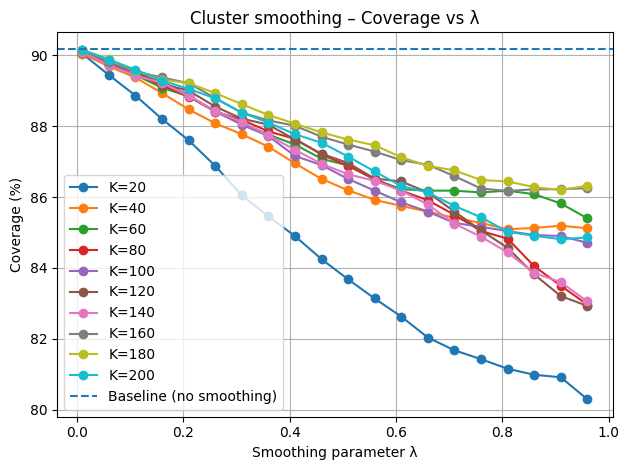

In [ ]:
plt.figure()

for K, vals in plot_data_clustering.items():
    if K == "BASELINE": 
        continue
    lambdas = np.array(vals["lambda"])
    coverage = np.array(vals["coverage"]) * 100   
    plt.plot(lambdas, coverage, marker="o", label=f"K={K}")

plt.axhline(y =0.9016*100, linestyle="--", label="Baseline (no smoothing)")
plt.xlabel("Smoothing parameter λ")
plt.ylabel("Coverage (%)")
plt.title("Cluster smoothing – Coverage vs λ")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [49]:
print(plot_data_clustering[180]['coverage'][0])
print(plot_data_clustering[200]['coverage'][0])
print(plot_data_clustering[20]['coverage'][0])

0.9015
0.9014
0.9004


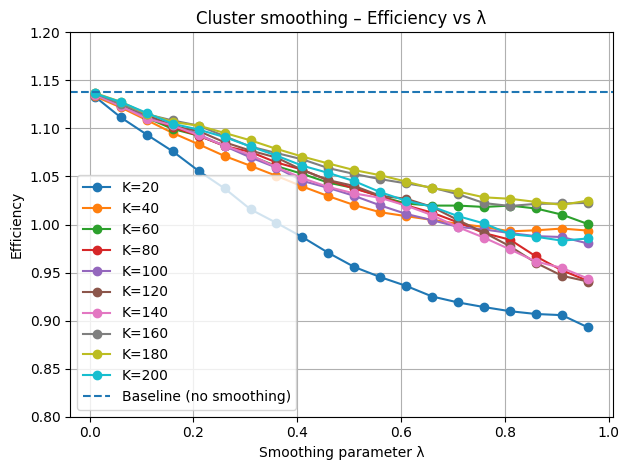

In [ ]:
plt.figure()

for K, vals in plot_data_clustering.items():
    if K == "BASELINE":  
        continue
    lambdas = np.array(vals["lambda"])
    coverage = np.array(vals["efficiency"])  
    plt.plot(lambdas, coverage, marker="o", label=f"K={K}")

plt.axhline(y =1.1376, linestyle="--", label="Baseline (no smoothing)")
plt.xlabel("Smoothing parameter λ")
plt.ylabel("Efficiency")
plt.title("Cluster smoothing – Efficiency vs λ")
plt.legend()
plt.grid(True)
plt.ylim(0.8, 1.20)
plt.tight_layout()

In [48]:
print(plot_data_clustering[180]['efficiency'][0])
print(plot_data_clustering[200]['efficiency'][0])

1.1369
1.1364


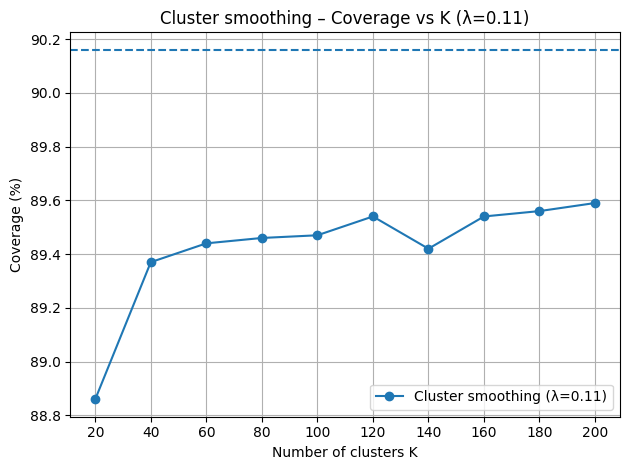

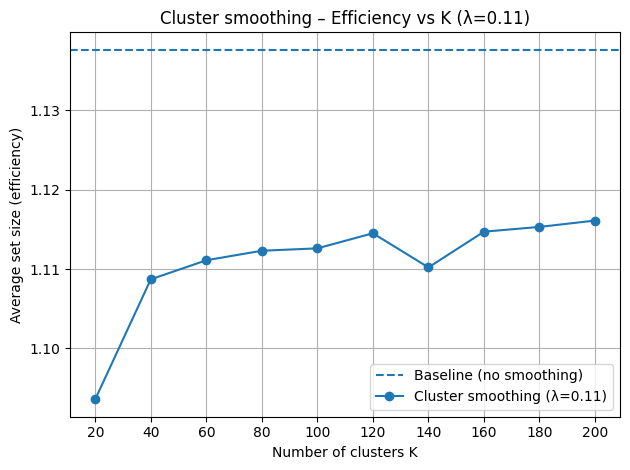

In [ ]:

K_values = np.arange(20, 201, 20)  
target_lambda = 0.11

eff_vals = []
cov_vals = []

for K in K_values:
    data = plot_data_clustering[K]
    lambdas = np.array(data["lambda"])
    efficiencies = np.array(data["efficiency"])
    coverages = np.array(data["coverage"])

    idx = (np.abs(lambdas - target_lambda)).argmin()
    
    eff_vals.append(efficiencies[idx])
    cov_vals.append(coverages[idx])

eff_vals = np.array(eff_vals)
cov_vals = np.array(cov_vals)


# Plot Coverage vs K 
plt.figure()
plt.plot(K_values, cov_vals*100, marker="o", label=f"Cluster smoothing (λ={target_lambda})")
plt.xlabel("Number of clusters K")
plt.ylabel("Coverage (%)")
plt.title(f"Cluster smoothing – Coverage vs K (λ={target_lambda})")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.axhline(y =0.9016*100, linestyle="--", label="Baseline (no smoothing)")

# Plot Efficiency vs K 
plt.figure()
plt.axhline(y =1.1376, linestyle="--", label="Baseline (no smoothing)")
plt.plot(K_values, eff_vals, marker="o", label=f"Cluster smoothing (λ={target_lambda})")
plt.xlabel("Number of clusters K")
plt.ylabel("Average set size (efficiency)")
plt.title(f"Cluster smoothing – Efficiency vs K (λ={target_lambda})")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.tight_layout()


### 6.2 kNN

In [83]:
folder = "code/examples/scratch/rhti/conformal"
alpha = 0.1
target_cov = 1.0 - alpha

holdout = torch.load(folder + "/holdout_predictions.pth", weights_only=False)
val = torch.load(folder + "/val_predictions.pth", weights_only=False)
test = torch.load(folder + "/test_predictions.pth", weights_only=False)
feats = np.load(folder + "/holdout_features.npz")["features"]

cal_labels = holdout["labels"]
cal_outputs = holdout["outputs"]
n_cal = len(cal_labels)
cal_scores = 1.0 - cal_outputs[np.arange(n_cal), cal_labels]

data = {
    "cal_scores": cal_scores,
    "cal_feats": feats,
    "val_labels": val["labels"],
    "val_outputs": val["outputs"],
    "test_labels": test["labels"],
    "test_outputs": test["outputs"],
}


In [84]:
# kNN sweep

knn_results_global = []

print("Calibration Results (k-NN)")

baseline_metrics = evaluate_and_return_metrics(qhat_base, data["val_outputs"], data["val_labels"], "Baseline CAL: ")

ks = list(range(2, 22, 2)) #[2, 8, 14]
lambdas = [i * 0.05 for i in range(0, 21)] #[0.01, 0.025, 0.05, 0.1]

for k in ks:
    print(f"kNN k={k}")
    nbrs = NearestNeighbors(n_neighbors=k, metric="euclidean", n_jobs=-1)
    nbrs.fit(data["cal_feats"])
    _, indices = nbrs.kneighbors(data["cal_feats"])

    neighbor_means = data["cal_scores"][indices].mean(axis=1)

    for lam in lambdas:
        smooth_scores = (1.0 - lam) * data["cal_scores"] + lam * neighbor_means
        qhat = compute_qhat(smooth_scores, alpha)
        
        metrics = evaluate_and_return_metrics(qhat, data["val_outputs"], data["val_labels"], "CAL: ")

        config_name = f"k={k}, lambda={lam}"
        knn_results_global.append((config_name, metrics))
        
        print(f"    lambda={lam:}: {metrics['result_str']}")


Calibration Results (k-NN)
kNN k=2
    lambda=0.0: CAL: Coverage: 90.16%, Eff: 1.14, Single: 94.96955%
    lambda=0.05: CAL: Coverage: 89.99%, Eff: 1.13, Single: 95.02047%
    lambda=0.1: CAL: Coverage: 89.87%, Eff: 1.13, Single: 95.01451%
    lambda=0.15000000000000002: CAL: Coverage: 89.72%, Eff: 1.12, Single: 95.03490%
    lambda=0.2: CAL: Coverage: 89.75%, Eff: 1.12, Single: 95.04546%
    lambda=0.25: CAL: Coverage: 89.70%, Eff: 1.12, Single: 95.03490%
    lambda=0.30000000000000004: CAL: Coverage: 89.61%, Eff: 1.12, Single: 95.12740%
    lambda=0.35000000000000003: CAL: Coverage: 89.56%, Eff: 1.12, Single: 95.13123%
    lambda=0.4: CAL: Coverage: 89.59%, Eff: 1.12, Single: 95.14053%
    lambda=0.45: CAL: Coverage: 89.57%, Eff: 1.12, Single: 95.14117%
    lambda=0.5: CAL: Coverage: 89.44%, Eff: 1.11, Single: 95.16573%
    lambda=0.55: CAL: Coverage: 89.41%, Eff: 1.11, Single: 95.15707%
    lambda=0.6000000000000001: CAL: Coverage: 89.35%, Eff: 1.11, Single: 95.20880%
    lambda=0.6

#### knn Plots

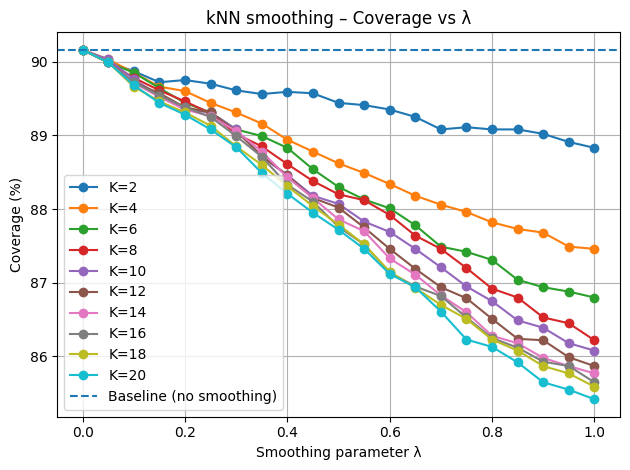

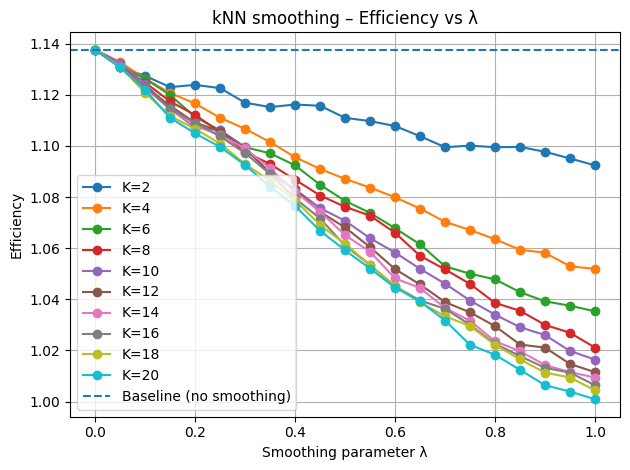

In [85]:
plot_data_kNN = {}  

for label, metrics in knn_results_global:
    if label == "BASELINE":
        K = "BASELINE"
        lam = None
    else:
        match = re.match(r"k=(\d+), lambda=([0-9.]+)", label)
        if match:
            K = int(match.group(1))
            lam = float(match.group(2))
        else:
            continue

    if K not in plot_data_kNN:
        plot_data_kNN[K] = {"lambda": [], "coverage": [], "efficiency": [],
                        "singleton_cov": [], "qhat": []}

    plot_data_kNN[K]["lambda"].append(lam)
    plot_data_kNN[K]["coverage"].append(float(metrics["coverage"]))
    plot_data_kNN[K]["efficiency"].append(float(metrics["efficiency"]))
    plot_data_kNN[K]["singleton_cov"].append(float(metrics["singleton_cov"]))
    plot_data_kNN[K]["qhat"].append(float(metrics["qhat"]))
    
plt.figure()

for K, vals in plot_data_kNN.items():
    lambdas = np.array(vals["lambda"])
    coverage = np.array(vals["coverage"]) * 100   
    plt.plot(lambdas, coverage, marker="o", label=f"K={K}")

plt.axhline(y =0.9016*100, linestyle="--", label="Baseline (no smoothing)")
plt.xlabel("Smoothing parameter λ")
plt.ylabel("Coverage (%)")
plt.title("kNN smoothing – Coverage vs λ")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure()



for K, vals in plot_data_kNN.items():
    lambdas = np.array(vals["lambda"])
    efficiency = np.array(vals["efficiency"]) 
    plt.plot(lambdas, efficiency, marker="o", label=f"K={K}")

plt.axhline(y =1.1376, linestyle="--", label="Baseline (no smoothing)")
plt.xlabel("Smoothing parameter λ")
plt.ylabel("Efficiency")
plt.title("kNN smoothing – Efficiency vs λ")
plt.legend()
plt.grid(True)
plt.tight_layout()





In [ ]:
# save to excel
dfs = {}

for K, metrics in plot_data_kNN.items():
    filtered = {key: val for key, val in metrics.items() if key != "lambda"}

    df = pd.DataFrame(filtered)
    dfs[K] = df


output_path = "kNN_results.xlsx"

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for K, df in dfs.items():
        df.to_excel(writer, sheet_name=f"K_{K}", index=False)

print(f"Saved Excel file to {output_path}")

Saved Excel file to kNN_results.xlsx


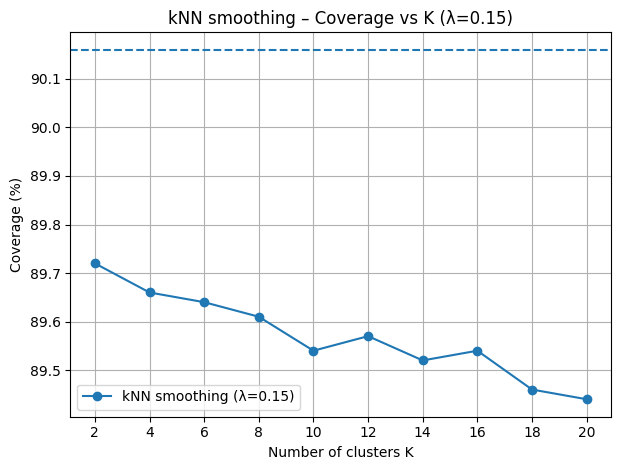

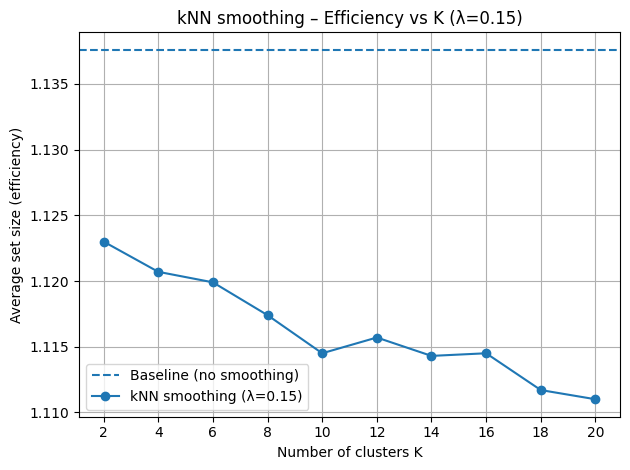

In [ ]:

K_values = np.arange(2, 22, 2)  
target_lambda = 0.15

eff_vals = []
cov_vals = []

for K in K_values:
    data = plot_data_kNN[K]
    lambdas = np.array(data["lambda"])
    efficiencies = np.array(data["efficiency"])
    coverages = np.array(data["coverage"])
    
    # Find the index closest to target_lambda
    idx = (np.abs(lambdas - target_lambda)).argmin()
    
    eff_vals.append(efficiencies[idx])
    cov_vals.append(coverages[idx])

eff_vals = np.array(eff_vals)
cov_vals = np.array(cov_vals)


# Plot Coverage vs K 
plt.figure()
plt.plot(K_values, cov_vals*100, marker="o", label=f"kNN smoothing (λ={target_lambda})")
plt.xlabel("Number of clusters K")
plt.ylabel("Coverage (%)")
plt.title(f"kNN smoothing – Coverage vs K (λ={target_lambda})")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.axhline(y =0.9016*100, linestyle="--", label="Baseline (no smoothing)")

# Plot Efficiency vs K
plt.figure()
plt.axhline(y =1.1376, linestyle="--", label="Baseline (no smoothing)")
plt.plot(K_values, eff_vals, marker="o", label=f"kNN smoothing (λ={target_lambda})")
plt.xlabel("Number of clusters K")
plt.ylabel("Average set size (efficiency)")
plt.title(f"kNN smoothing – Efficiency vs K (λ={target_lambda})")
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.tight_layout()


## 7.Testing Results

Based on the output above, we identified the best parameters: K = 110 and λ = 0.02 for clustering, and k = 8 and λ = 0.025 for k-NN. We will use these parameters for testing data:

In [99]:
folder = "code/examples/scratch/rhti/conformal"
alpha = 0.1
target_cov = 1.0 - alpha

holdout = torch.load(folder + "/holdout_predictions.pth", weights_only=False)
val = torch.load(folder + "/val_predictions.pth", weights_only=False)
test = torch.load(folder + "/test_predictions.pth", weights_only=False)
feats = np.load(folder + "/holdout_features.npz")["features"]

cal_labels = holdout["labels"]
cal_outputs = holdout["outputs"]
n_cal = len(cal_labels)
cal_scores = 1.0 - cal_outputs[np.arange(n_cal), cal_labels]

data = {
    "cal_scores": cal_scores,
    "cal_feats": feats,
    "val_labels": val["labels"],
    "val_outputs": val["outputs"],
    "test_labels": test["labels"],
    "test_outputs": test["outputs"],
}


In [107]:
def find_qhat_by_config(results_list, target_config_name):
    for name, metrics in results_list:
        if name == target_config_name:
            return name, metrics["qhat"]
    return "Fallback (Baseline Qhat)", qhat_base 

target_clust_name = "K=80, lambda=0.11"
best_clust_name, best_clust_qhat = find_qhat_by_config(clustering_results_global[1:], target_clust_name)

target_knn_name = "k=10, lambda=0.15000000000000002"
best_knn_name, best_knn_qhat = find_qhat_by_config(knn_results_global, target_knn_name)


final_test_results = []
test_outputs = data["test_outputs"]
test_labels = data["test_labels"]

baseline_test_metrics = evaluate_and_return_metrics(qhat_base, test_outputs, test_labels, "Baseline TEST: ")
final_test_results.append(("BASELINE", baseline_test_metrics))


clust_test_metrics = evaluate_and_return_metrics(best_clust_qhat, test_outputs, test_labels, f"{best_clust_name} TEST: ")
final_test_results.append((best_clust_name, clust_test_metrics))

knn_test_metrics = evaluate_and_return_metrics(best_knn_qhat, test_outputs, test_labels, f"{best_knn_name} TEST: ")
final_test_results.append((best_knn_name, knn_test_metrics))


print("Test Evaluation (Using Best Parameters)")

for config, result in final_test_results:
    print(f"\n--- {config} ---")
    print(result["result_str"])

print("\n")

Test Evaluation (Using Best Parameters)

--- BASELINE ---
Baseline TEST: Coverage: 89.78%, Eff: 1.14, Single: 94.31087%

--- K=80, lambda=0.11 ---
K=80, lambda=0.11 TEST: Coverage: 89.09%, Eff: 1.11, Single: 94.49637%

--- k=10, lambda=0.15000000000000002 ---
k=10, lambda=0.15000000000000002 TEST: Coverage: 89.16%, Eff: 1.11, Single: 94.45742%




## 8. Summary
- Baseline coverage is ~90% with an efficiency of ~1.14.
- Cluster smoothing performs best at K = 80 and λ = 0.11, as this maintain the coverage near 90% while still achieving a lower efficiency (1.14 -> 1.11).
- k-NN performs best at k = 10 and λ = 0.15, as this maintain the coverage near 90% while still achieving a lower efficiency (1.14 -> 1.11).
- These optimal parameters yield a coverage of 89.09% and 89.16% for clustering and k-NN, respectively. 

The notebook contains the full reproducible pipeline.